# Multiple regression w/ TF Keras

Link to this notebook: https://colab.research.google.com/drive/1TGesb0A-yWQdgQ9ODSbcNlhvOdwIN5GP#scrollTo=e3MyhM62HPMb

## Problem statement


You’ll attempt to predict the median price of homes in a given Boston suburb in the
mid-1970s, given data points about the suburb at the time, such as the crime rate, the
local property tax rate, and so on. It  has  relatively  few  data  points:  only  506,  split between 404 training samples and 102 test samples. And each feature in the input data
(for example, the crime rate) has a different scale. For instance, some values are pro-
portions, which take values between 0 and 1; others take values between 1 and 12, oth-
ers between 0 and 100, and so on.

Reasonable performance for models evaluated using Mean Squared Error (MSE) are around 20 in squared thousands of dollars (or $4,500 if you take the square root). This is a nice target to aim for with our neural network model.

This is a classical dataset, so it is available directly in keras

In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

As  you  can  see,  you  have  404  training  samples  and  102  test  samples,  each  with  13
numerical features, such as per capita crime rate, average number of rooms per dwell-
ing, accessibility to highways, and so on.

  The  targets  are  the  median  values  of  owner-occupied  homes,  in  thousands  of
dollars:

In [4]:
  train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

The prices are typically between \$10,000 and \$50,000. If that sounds cheap, remember that this was the mid-1970s, and these prices aren’t adjusted for inflation.

## Preping the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous
data, but it would definitely make learning more difficult. A widespread best practice
to deal with such data is to do feature-wise normalization: **for each feature in the input
data (a column in the input data matrix), you subtract the mean of the feature and
divide by the standard deviation, so that the feature is centered around 0 and has a
unit standard deviation**. This is easily done in Numpy.

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Note that the quantities used for normalizing the test data are computed using the
training data. You should **never use in your workflow any quantity computed on the
test data**, even for something as simple as data normalization.

## Building the network

In [5]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  # model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

The network ends (last layer) with a single unit and no activation (it will be a linear layer). This is
a typical setup for scalar regression (a regression where you’re trying to predict a single
continuous value). Applying an activation function would constrain the range the output can take; for instance, if you applied a sigmoid activation function to the last layer,
the network could only learn to predict values between 0 and 1. Here, because the last
layer is purely linear, the network is free to learn to predict values in any range.

 Note that you compile the network with the mse loss function—mean squared error,
the square of the difference between the predictions and the targets. This is a widely
used loss function for regression problems.
 You’re also monitoring a new metric during training: mean absolute error (MAE). It’s
the  absolute  value  of  the  difference  between  the  predictions  and  the  targets.  For
instance, an MAE of 0.5 on this problem would mean your predictions are off by $500
on average.

## Validating your approach using K-fold validation


To evaluate your network while you keep adjusting its parameters (such as the number of epochs used for training), you could split the data into a training set and a validation set. But because you have so few data points, the validation set would end up being very small (for instance, about 100 examples. As a consequence, the validation scores might change a lot depending on which data points you chose to use for validation and which you chose for training: the validation scores might have a high variance with regard to the validation split. This would prevent you from reliably evaluating your model.

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained. In terms of code, this is straightforward.

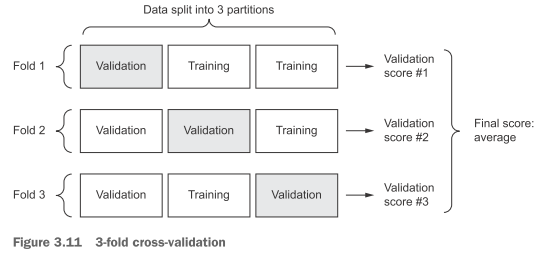

In [14]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [15]:
for i in range(k):
  print('processing fold #', i)
  # get the validation portion for the i-th fold
  val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

  # get the training portion for the i-th fold
  partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

  model = build_model()
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [16]:
all_scores
# [3.8417842388153076, 3.531492233276367, 3.379641056060791, 4.858107089996338]
# [4.329324722290039, 4.655668258666992, 4.1663312911987305, 5.461818695068359]

[5.959156036376953, 5.509171485900879, 5.001978397369385, 5.499080657958984]

In [17]:
np.mean(all_scores)
# 3.902756154537201
# 4.65328574180603

5.49234664440155

The different runs do indeed show rather different validation scores, from 2.1 to 2.6. The average (2.4) is a much more reliable metric than any single score—that’s the entire point of K-fold cross-validation. In this case, you’re off by \$2400 on average, which is significant considering that the prices range from \$10,000 to \$50,000.

## More epochs?

 Let’s try training the network a bit longer: 500 epochs. To keep a record of how
well the model does at each epoch, you’ll modify the training loop to save the per-
epoch validation score log.

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


You can then compute the average of the per-epoch MAE scores for all folds.

In [20]:
average_mae_history = [
  np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

TypeError: ignored

Plotting validation scores

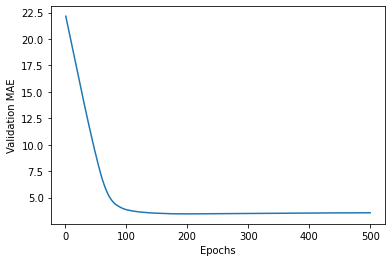

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance. Let’s do the following:
- Omit the first 10 data points, which are on a different scale than the rest of the curve.
- Replace each point with an exponential moving average of the previous points,
to obtain a smooth curve.

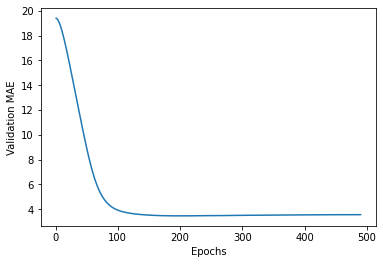

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


According to this plot, it seems that validation MAE stops improving significantly after 45 epochs. Past that point, we start overfitting.

Once we are done tuning other parameters of our model (besides the number of epochs, we could also adjust the size of the hidden layers), we can train a final "production" model on all of the training data, with the best parameters, then look at its performance on the test data:

In [ ]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=300, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 235.5638 - mae: 14.6020


In [ ]:
test_mae_score

14.601966857910156

We are still off by a bit.

## Intermediate summary
Here's what you should take away from this example:

- Regression is done using different loss functions from classification;
- Mean Squared Error (MSE) is a commonly used loss function for regression.
- Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" does not apply for regression. A common regression metric is Mean Absolute Error (MAE).
- When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
- When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.
- When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), in order to avoid severe overfitting.

## All code in one place (usefull for experimentation)

In [21]:
from keras import models
from keras import layers
import numpy as np
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(12, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(12, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

np.mean(all_scores)

# 2.63 64 64 1
# 2.37 32 32 1
# 2.28 16 16 1
# 2.42 8 8 1

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


2.352830559015274

## Predictions

## K-fold cross validation with scikit

## How do we compare to an XGBoost model?

In [24]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [29]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.4,learning_rate=0.09,max_depth=10,alpha=15,n_estimators=255)
xg_reg.fit(train_data,train_targets)
preds = xg_reg.predict(test_data)

rmse = np.sqrt(mean_squared_error(test_targets, preds))
print('RMSE=%f' % (rmse))

for i in zip(test_targets, preds):
  print(i)

RMSE=3.489885
(7.2, 9.537591)
(18.8, 18.782604)
(19.0, 19.849226)
(27.0, 26.850853)
(22.2, 24.209242)
(24.5, 19.833239)
(31.2, 27.796228)
(22.9, 23.668798)
(20.5, 18.975986)
(23.2, 20.280224)
(18.6, 18.67205)
(14.5, 17.513765)
(17.8, 14.626686)
(50.0, 42.05149)
(20.8, 16.095112)
(24.3, 21.210009)
(24.2, 23.697853)
(19.8, 23.392826)
(19.1, 19.388308)
(22.7, 21.00864)
(12.0, 14.566138)
(10.2, 13.840474)
(20.0, 21.489845)
(18.5, 19.182259)
(20.9, 20.11541)
(23.0, 19.890045)
(27.5, 27.8448)
(30.1, 30.446575)
(9.5, 10.937732)
(22.0, 20.327011)
(21.2, 20.61641)
(14.1, 14.591629)
(33.1, 32.503033)
(23.4, 23.23718)
(20.1, 18.085102)
(7.4, 10.060547)
(15.4, 16.581722)
(23.8, 20.95589)
(20.1, 18.510784)
(24.5, 25.92633)
(33.0, 29.949444)
(28.4, 25.952826)
(14.1, 14.306227)
(46.7, 41.8205)
(32.5, 28.700413)
(29.6, 27.588957)
(28.4, 27.923243)
(19.8, 20.34305)
(20.2, 19.022724)
(25.0, 25.134832)
(35.4, 33.22277)
(20.3, 20.359468)
(9.7, 11.286582)
(14.5, 14.877706)
(34.9, 34.48363)
(26.6, 26.51434)

### Normalization?

In [30]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data_n = (train_data - train_data.mean(axis=0)) / train_data.std(axis=0)
train_targets_n = (train_targets - train_targets.mean(axis=0)) / train_targets.std(axis=0)
test_data_n = (test_data - test_data.mean(axis=0)) / test_data.std(axis=0)
test_targets_n = (test_targets - test_targets.mean(axis=0)) / test_targets.std(axis=0)

print(train_data_n)

[[-0.27224633 -0.48361547 -0.43576161 ...  1.14850044  0.44807713
   0.8252202 ]
 [-0.40342651  2.99178419 -1.33391162 ... -1.71818909  0.43190599
  -1.32920239]
 [ 0.1249402  -0.48361547  1.0283258  ...  0.78447637  0.22061726
  -1.30850006]
 ...
 [-0.40202987  0.99079651 -0.7415148  ... -0.71712291  0.07943894
  -0.67776904]
 [-0.17292018 -0.48361547  1.24588095 ... -1.71818909 -0.98764362
   0.42083466]
 [-0.40422614  2.04394792 -1.20161456 ... -1.30866202  0.23317118
  -1.15392266]]


In [31]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.4,learning_rate=0.17,max_depth=10,alpha=15,n_estimators=150)
xg_reg.fit(train_data_n,train_targets_n)
preds_n = xg_reg.predict(test_data_n)

rmse = np.sqrt(mean_squared_error(test_targets_n, preds_n))
print ('RMSE=%f'% (rmse))

for i in zip(test_targets_n, preds_n):
  print(i)

RMSE=0.456317
(-1.7403296575360925, -1.1657008)
(-0.46893051528077956, -0.36460453)
(-0.44700984041430875, -0.26663727)
(0.42981715424452765, 0.5606263)
(-0.09627904255077424, 0.12974998)
(0.1558087184136413, 0.040332794)
(0.8901513264404167, 0.6422758)
(-0.019556680518126132, 0.121029586)
(-0.2826047789157769, -0.30709976)
(0.01332433178158031, -0.1945113)
(-0.49085119014725037, -0.44284588)
(-0.9402250249099042, -0.55119205)
(-0.5785338896131341, 0.0013162196)
(2.9506947638886825, 1.8346435)
(-0.24972376661607046, -0.29319972)
(0.13388804354717046, -0.16218442)
(0.12292770611393486, 0.15337166)
(-0.359327140948425, 0.26398468)
(-0.4360495029810731, -0.3378641)
(-0.041477355384596966, -0.37784505)
(-1.2142334607407905, -0.21285266)
(-1.4115195345390288, -0.73313797)
(-0.3374064660819542, -0.07694447)
(-0.501811527580486, -0.16785413)
(-0.23876342918283525, 0.15111455)
(-0.008596343084890523, -0.16596687)
(0.48461884141070494, 0.3993454)
(0.769587614674827, 0.68396264)
(-1.488241896571

In [32]:
preds = preds_n * test_targets.std(axis=0) + test_targets.mean(axis=0)
print ('RMSE=%f'% (np.sqrt(mean_squared_error(test_targets, preds))))
for i in zip(test_targets, preds):
  print(i)

RMSE=4.163346
(7.2, 12.442803)
(18.8, 19.75185)
(19.0, 20.645685)
(27.0, 28.193478)
(22.2, 24.262245)
(24.5, 23.44642)
(31.2, 28.938433)
(22.9, 24.182682)
(20.5, 20.276512)
(23.2, 21.30375)
(18.6, 19.03799)
(14.5, 18.049461)
(17.8, 23.09044)
(50.0, 39.817368)
(20.8, 20.403334)
(24.3, 21.598692)
(24.2, 24.477766)
(19.8, 25.486977)
(19.1, 19.995825)
(22.7, 19.631046)
(12.0, 21.136406)
(10.2, 16.389423)
(20.0, 22.376406)
(18.5, 21.546963)
(20.9, 24.457172)
(23.0, 21.564182)
(27.5, 26.721983)
(30.1, 29.318775)
(9.5, 11.084747)
(22.0, 21.30706)
(21.2, 21.026527)
(14.1, 17.253996)
(33.1, 31.774548)
(23.4, 24.10595)
(20.1, 19.255344)
(7.4, 10.371179)
(15.4, 15.637913)
(23.8, 17.973076)
(20.1, 19.82713)
(24.5, 28.426151)
(33.0, 28.606983)
(28.4, 29.380632)
(14.1, 14.850099)
(46.7, 37.52398)
(32.5, 28.096588)
(29.6, 25.799335)
(28.4, 30.212421)
(19.8, 22.653194)
(20.2, 20.152515)
(25.0, 24.371214)
(35.4, 34.25319)
(20.3, 20.915737)
(9.7, 11.226897)
(14.5, 16.843306)
(34.9, 32.07755)
(26.6, 27.9